<a href="https://colab.research.google.com/github/statistics-jun/2022-1-ESAA/blob/main/ESAA_Week12_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022-1 ESAA 5기 김혜준 개념 필사 - 0527(금) 12주차 과제
## <파이썬 딥러닝 텐서플로>
## PART 03 케라스(Keras)

### 01 딥러닝 준비
* 케라스 API : 고수준 딥러닝 라이브러리, GPU 연산을 수행하는 기능을 직접 실행하지 않고 텐서플로, CNTK 등의 백엔드 엔진을 지정하여 사용
  - 2.4 버전 이후 오직 텐서플로만 백엔드로 지원
* 텐서플로2 : 케라스 API를 내재화


#### 1-1 주요 용어


##### 1-1-1 하이퍼파라미터(hyper-parameter)
* 하이퍼파라미터 : 딥러닝뿐만 아니라 머신러닝 모델을 훈련할 때 사용자가 직접 설정해주는 설정 값, 모델 성능 및 결과에 중요한 영향 미침, 별도 지정 없는 경우 기본값 자동 적용
* 하이퍼파라미터 튜닝 : 하이퍼파라미터의 값을 조절하는 행위

##### 1-1-2 과소적합 vs. 과대적합(underfitting vs. overfitting)
* 모델 학습 후 예측 성능이 떨어지는 경우
  - 예측 데이터가 학습 데이터와 다른 분포
  - 학습 데이터가 특정 레이블에 편향된 데이터
* 과소적합 : 모델이 충분히 학습되지 않은 경우 예측 성능이 떨어지는 상태
* 과대적합 : 학습 데이터를 지나치게 반복 학습하게 되어 과하게 적합된 상태 -> 주어진 훈련 데이터에 대한 예측 성능이 좋지만, 예측 데이터에 대한 예측 오차가 발생할 확률 증가

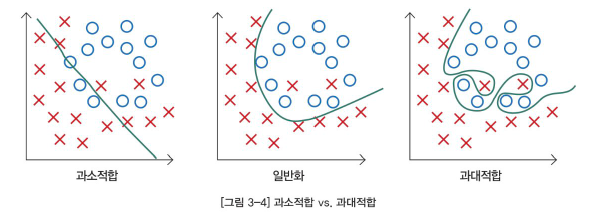

* 모델 학습 시 과소적합과 과대적합 문제를 최소화하면서 정확도를 가장 높일 수 있도록 해야 함
* 훈련 데이터는 예측 데이터와 동일한 분포로 구성, 불필요한 노이즈는 데이터 분석 및 전처리를 통해 해소
* 훈련 데이터 일부를 검증 데이터로 활용 -> 검증 성능이 가장 좋은 구간을 모델의 가장 이상적으로 학습된 지점이라 판단하는 방법으로 최종 모델 결정 

##### 1-1-3 에포크(epoch)
* 딥러닝 : 데이터셋을 학습하는 과정을 여러 번 반복하면서 최적의 모델 가중치를 찾는 과정
* 에포크 : 딥러닝 모델이 반복 훈련을 할 때 데이터셋을 전부 학습에 사용하는 1회의 훈련 루프
  - 과소적합 -> epoch 증가
  - 과대적합 -> epoch 감소

##### 1-1-4 손실함수(loss function)
* 손실함수 : 예측 값과 정답 값의 차이 또는 오차
* 텐서플로는 사전 정의된 손실함수를 함수형과 클래스형으로 제공
* 사용자가 모델에 따라 다르게 정의
  - 지도 학습
    - 분류
      - 이진 분류 : `binary_crossentropy`
       
        출력층의 활성화 함수 *sigmoid*
      - 다중 분류
        - 클래스가 원핫 벡터인 경우 : `categorical_crossentropy`
        - 클래스가 레이블 숫자 값인 경우 : `sparse_categorical_crossentropy`

        출력층의 활성화 함수 *softmax*
    - 회귀 : MSE, MAE, Huber

  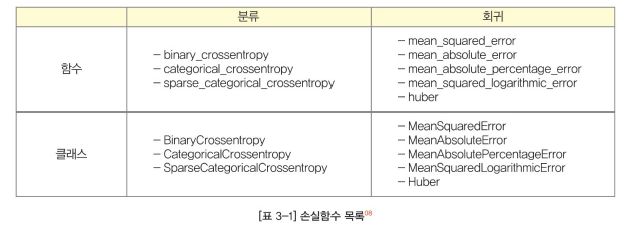


In [1]:
import tensorflow as tf

# 클래스
tf.keras.losses.BinaryCrossentropy()

# 함수
tf.keras.losses.binary_crossentropy

<function keras.losses.binary_crossentropy>

##### 1-1-5 경사하강법(gradient descent)
* 딥러닝 모델을 훈련할 때, 모델 내부의 가중치에 대한 미분 값을 구하고 목적 함수 값이 낮아지는 방향으로 차감하면서 최소 함수 값을 갖도록 하는 방법

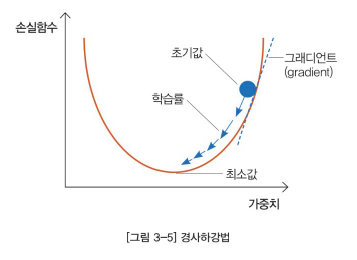

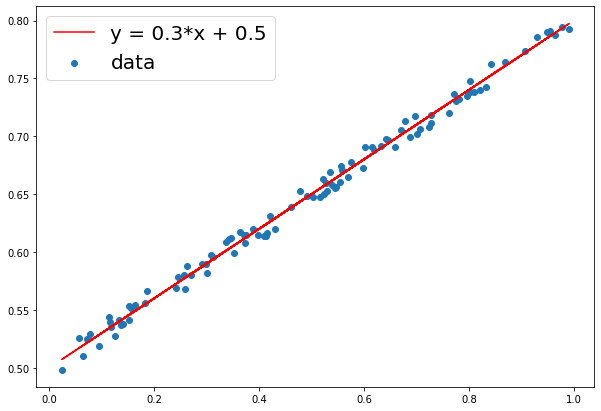

w: 0.3, b: 0.5


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 샘플에 활용할 데이터셋 만들기
def make_linear(w=0.5, b=0.8, size=50, noise=1.0):
    x = np.random.rand(size)
    y = w * x + b
    noise = np.random.uniform(-abs(noise), abs(noise), size=y.shape)
    yy = y + noise # y 값 생성 시 약간의 노이즈 추가
    plt.figure(figsize=(10, 7))
    plt.plot(x, y, color='r', label=f'y = {w}*x + {b}')
    plt.scatter(x, yy, label='data')
    plt.legend(fontsize=20)
    plt.show()
    print(f'w: {w}, b: {b}')
    return x, yy

x, y = make_linear(w=0.3, b=0.5, size=100, noise=0.01)

> 실제 생성된 y 데이터는 식과 완벽히 일치하지 않고 약간의 노이즈가 추가된 것을 확인 가능

In [3]:
# 최대 반복 횟수
num_epoch = 1000

# 학습률 (learning_rate)
learning_rate = 0.005

# 에러 기록
errors = []

# random 한 값으로 w, b를 초기화
w = np.random.uniform(low=0.0, high=1.0)
b = np.random.uniform(low=0.0, high=1.0)

for epoch in range(num_epoch):
    # Hypothesis 정의
    y_hat = w * x + b
    
    # Loss Function 정의
    # 0.5는 가중치에 대한 그래디언트를 계산하기 쉽도록 추가된 상수 값
    error = 0.5*((y_hat - y) ** 2).sum()
    if error < 0.005: # 오차가 0.005 이내로 수렴하면 반복문 종료
        break
    # Gradient 미분 계산
    # 손실함수를 w, b에 대한 각각의 편미분 값을 구한 뒤 학습률 계수를 곱하여 이전의 w, b로부터 차감
    w = w - learning_rate * ((y_hat - y) * x).sum()
    b = b - learning_rate * (y_hat - y).sum()
    
    errors.append(error)

    if epoch % 5 == 0:
        print("{0:2} w = {1:.5f}, b = {2:.5f} error = {3:.5f}".format(epoch, w, b, error))
    
print("----" * 15)
print("{0:2} w = {1:.1f}, b = {2:.1f} error = {3:.5f}".format(epoch, w, b, error))

 0 w = 0.72258, b = 0.58314 error = 33.12252
 5 w = 0.56063, b = 0.36653 error = 0.25252
10 w = 0.52603, b = 0.38240 error = 0.19050
15 w = 0.49667, b = 0.39766 error = 0.14477
20 w = 0.47113, b = 0.41095 error = 0.11014
25 w = 0.44890, b = 0.42252 error = 0.08390
30 w = 0.42954, b = 0.43259 error = 0.06402
35 w = 0.41270, b = 0.44136 error = 0.04896
40 w = 0.39804, b = 0.44898 error = 0.03755
45 w = 0.38528, b = 0.45562 error = 0.02891
50 w = 0.37418, b = 0.46140 error = 0.02236
55 w = 0.36451, b = 0.46643 error = 0.01740
60 w = 0.35610, b = 0.47081 error = 0.01365
65 w = 0.34877, b = 0.47462 error = 0.01080
70 w = 0.34240, b = 0.47794 error = 0.00864
75 w = 0.33685, b = 0.48083 error = 0.00701
80 w = 0.33203, b = 0.48334 error = 0.00577
------------------------------------------------------------
85 w = 0.3, b = 0.5 error = 0.00484


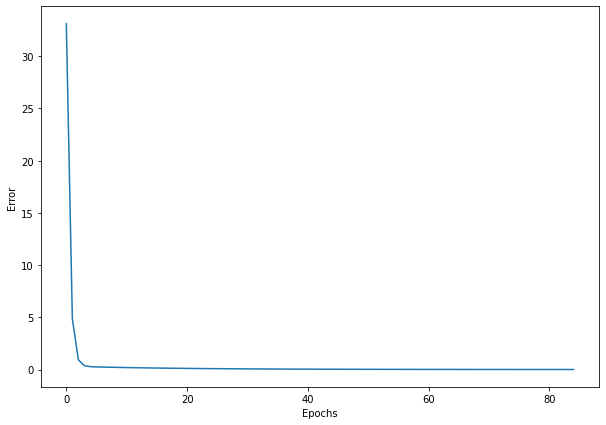

In [4]:
plt.figure(figsize=(10, 7))
plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

> w, b 계수는 샘플 데이터셋을 생성할 때 설정한 w, b 계수와 비슷한 값

#### 1-2 딥러닝 프로세스

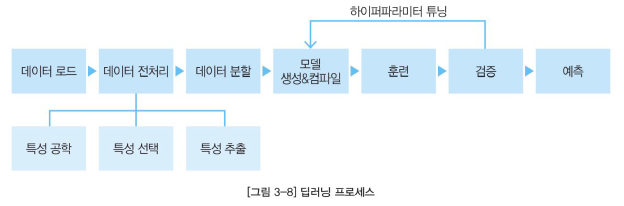

* 모델 훈련을 위한 필수 프로세스 : 데이터 전처리, 모델 생성, 컴파일, 훈련
* 예측 : 예측용 데이터셋을 입력하여 모델 예측 값을 얻는 과정
* 검증 : 모델의 성능을 평가하는 단계

##### 1-2-1 데이터 전처리
* 데이터를 모델에 주입하기 전에 데이터를 가공하는 단계
* 배열의 차원 변경, 스케일 조정

##### 1-2-2 모델 생성
* 모델의 구조를 정의하고 생성하는 단계
* 모델 생성 방법
  1. Sequential API : 순차적인 구조의 모델 구현
  2. Functional API : 다중 입력 및 출력을 가지는 복잡한 구조의 모델 구현
  3. Model Subclassing : 다중 입력 및 출력을 가지는 복잡한 구조의 모델 구현

##### 1-2-3 모델 컴파일
* 모델 인스턴스에 `compile()` 메소드를 적용하고, 생성된 모델 훈련에 사용할 손실함수, 옵티마이저, 평가지표 등 여러 가지 속성 값을 결정하는 과정

##### 1-2-4 모델 훈련
* 모델을 훈련하는 단계
* `fit()` 함수에 모델 훈련에 필요한 정보를 매개변수로 전달 : 훈련 데이터셋, 검증 데이터셋, epoch, 배치 크기 및 콜백 함수 지정

##### 1-2-5 모델 검증
* 훈련이 완료된 모델을 검증하는 단계
* 검증 데이터셋을 모델에 입력하고 모델의 예측 값을 정답과 비교하여 평가지표 계산 -> 모델의 성능 평가
* 검증 결과 바탕으로 다시 모델 생성 단계로 돌아가 모델 수정, 컴파일 및 훈련 과정을 거쳐 재평가하는 과정을 목표 성능에 도달할 때까지 반복

##### 1-2-6 모델 예측
* 훈련과 검증이 완료된 모델로 테스트셋에 대하여 모델이 예측하고 그 결과를 반환

### 02 단순 신경망 훈련

#### 2-1 선형회귀
* 회귀 분석 : 하나 이상의 독립변수들이 종속변수에 미치는 영향을 추정하는 통계 기법
  - 단순선형회귀 : 하나의 독립변수 X가 종속변수 Y에 미치는 영향을 추정, 1차 함수 관계로 표현
  
   - $ y = wx + b $
      - w : 가중치(weight)
      - b : 편향(bias)
      - w와 b를 업데이트하면서 Y에 가장 근사한 1차 함수식 완성

#### 2-2 뉴런(Neuron)
* 뉴런(= 노드) : 인공 신경망 모델을 구성하는 하나의 신경
* 신경망 : 여러 개의 레이어를 가지며, 1개의 레이어는 1개 이상의 뉴런으로 구성
* 뉴런 내부에 가중치 존재 : 오차 역전파를 통해 업데이트
  - 역전파 : 신경망을 구성하는 각 레이어와 관련된 손실함수를 미분한 결과인 그래디언트를 출력층에서 입력층 순으로 역으로 계산하고 저장

#### 2-3 Dense 레이어
* 심층 신경망 모델을 구성하는 가장 기본 레이어
* 각 레이어와 레이어 사이에 모든 뉴런이 서로 연결되어 있기 때문에 완전 연결층(Fully Connected Layer)이라고도 부름
* 텐서플로의 layer 모듈에 있는 Dense 레이어를 구성하는 노드 개수와 활성화 함수 지정 가능



In [5]:
import tensorflow as tf

# 10개의 노드로 이루어진 Dense 레이어
tf.keras.layers.Dense(10)

# ReLU 활성화 함수 적용
tf.keras.layers.Dense(10, activation='relu')

#### 2-4 데이터셋 만들기

In [6]:
# 샘플 데이터셋 생성
x = np.arange(1, 6) # 5개의 순차적인 x 데이터 생성

# y = 3x + 2
y = 3 * x + 2
print(x)
print(y)

[1 2 3 4 5]
[ 5  8 11 14 17]


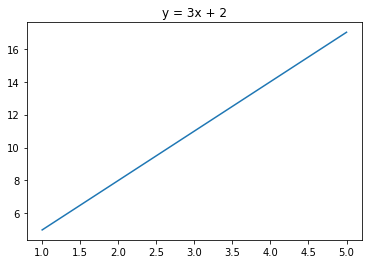

In [7]:
import matplotlib.pyplot as plt

# 시각화
plt.plot(x, y)
plt.title('y = 3x + 2')
plt.show()

#### 2-5 Sequential API
* 층을 이어 붙이듯 시퀀스에 맞게 일렬로 연결하는 방식
* 입력 레이어로부터 출력 레이어까지 순서를 가짐
* 입력 데이터는 시퀀스의 가장 앞에 위치한 층에 투입 -> 순서대로 각 층을 하나씩 통과하면서 딥러닝 연산 수행

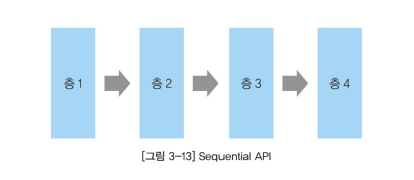

* 장점 : 케라스 모델을 생성하고 훈련하는 가장 간단한 방법
* 단점 : 2개 이상의 다중 입력이나 다중 출력을 갖는 복잡한 구조 구현 불가능 -> Functional API 사용

##### 2-5-1 모델 구조
* Sequantial API로 모델 생성하는 방법
  1. 리스트형 정의
  2. add 함수로 레이어 추가 : `add()` 메소드로 1개의 층 추가 -> 여러 개의 층을 추가하려면 add 함수를 반복해서 사용

  cf) Sequantial API의 레이어의 개수 제한 없음

In [8]:
import tensorflow as tf

# 리스트형
# 앞에 위치한 층부터 연산을 먼저 처리하고 순차적으로 다음 층의 연산 수행
model = tf.keras.Sequential([
        tf.keras.layers.Dense(10), 
        tf.keras.layers.Dense(5), 
        tf.keras.layers.Dense(1), 
])

In [9]:
# add 함수로 레이어 추가
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Dense(5))
model.add(tf.keras.layers.Dense(1))

##### 2-5-2 입력 데이터 형태
* 반드시 첫 번째 층에 input_shape 매개변수 지정 : 주입할 데이터셋의 shape을 튜플 또는 리스트로 지정


In [10]:
import tensorflow as tf
model = tf.keras.Sequential([
        # 입력 데이터의 shape=(150, 4)인 경우 input_shape 지정
        tf.keras.layers.Dense(10, input_shape=[4]), # input_shape=(4,)도 가능
        tf.keras.layers.Dense(5), 
        tf.keras.layers.Dense(1), 
])

##### 2-5-3 단순선형회귀모델 정의
* 1개의 뉴런을 가지는 Dense 레이어 한 개 사용하여 단순선형회귀모델 생성
  - 1개의 뉴런은 기울기(w)와 상수항(b)를 매개변수로 가짐
  - 1개의 출력 값은 y에 대한 모델의 예측 값
* Dense 레이어는 `use_bias = True`가 기본 설정되어 상수항 b 추가

In [11]:
# 단순선형회귀 모델 생성
model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=[1]) # 입력 데이터는 x 값을 나타내는 입력 변수 1개만 존재                   
])

#### 2-6 모델 요약
* `model.summary()` : 모델 구조, 층별 노드 개수, 훈련 시 업데이트할 파라미터 개수 등을 확인 가능
  - Total params : 모델 내부에 존재하는 모든 파라미터의 합계
  - Trainable params : 모델 훈련 시 업데이트할 파라미터의 총 개수
  - Non-trainable params : 훈련 시 업데이트하지 않을 파라미터의 총 개수

In [12]:
# 모델 요약
model.summary() # 단순선형회귀 모델의 업데이트 파라미터는 w, b 두 개 -> 총 파라미터 수가 2로 표기

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


#### 2-7 컴파일
* 모델의 훈련 과정에서 적용할 옵티마이저, 손실함수, 평가지표 등을 정의
* 옵티마이저, 손실함수, 평가지표를 지정하는 방법
  1. 클래스 인스턴스 : 학습률, 모멘텀 등의 하이퍼파라미터를 사용자가 직접 지정 가능
  2. 함수
  3. 사전 정의된 문자열 : 기본값으로 설정된 하이퍼파라미터 사용 -> 하이퍼파라미터 수정 어려움
* 기본 설정만으로도 딥러닝 모델의 성능은 잘 나오는 편

In [13]:
# 긴 문자열 지정
model.compile(optimizer='sgd', loss='mean_squared_error', 
              metrics=['mean_squared_error', 'mean_absolute_error'])

In [14]:
# 짧은 문자열 지정
model.compile(optimizer='sgd', loss='mse', metrics=['mse', 'mae'])

In [15]:
# 클래스 인스턴스 지정
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.005), 
              loss=tf.keras.losses.MeanAbsoluteError(), 
              metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                       tf.keras.metrics.MeanSquaredError()
                       ])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [16]:
# 컴파일
model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

#### 2-4 훈련
* 생성한 모델 인스턴스에 `fit(x, y, epoch)` 적용하여 모델 훈련(가중치 텐서 업데이트)
  - x : 훈련용 데이터셋의 입력
  - y : 훈련용 데이터셋의 정답에 해당하는 출력
  - epoch : 반복 훈련 수
  - 매 epoch가 끝날 때마다 훈련 데이터셋에 대한 손실과 평가지표 출력
  - `verbose=0` : 훈련 중간 과정 출력 생략
* fit() 메소드에 검증 데이터셋 옵션을 지정 -> 검증 셋에 대한 손실과 평가지표도 함께 출력

In [17]:
# 훈련
model.fit(x, y, epochs=5)

Epoch 1/5
1/1 [==============================] - 1s 519ms/step - loss: 66.9506 - mae: 7.7245
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 39.1550 - mae: 5.9506
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 22.9562 - mae: 4.5963
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 13.5154 - mae: 3.5623
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0129 - mae: 2.7727


> 5 epoch의 훈련 이후 손실함수는 8.0129, 평균절대오차는 2.7727
>
> 모델의 예측 오차인 손실 함수가 점점 줄어듦 -> 모델이 잘 학습되고 있음
>
> 반복 횟수가 충분치 않아 학습이 덜 된 상태 =  "과소적합" -> epoch를 늘려서 추가 학습을 통해 손실 낮출 필요

In [18]:
# 단순선형회귀 모델 생성
model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=[1])                    
])

# 컴파일
model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

# 훈련
history = model.fit(x, y, epochs=1200) # epoch별 훈련 손실과 평가지표가 딕셔너리 형태로 저장

Epoch 1/1200
1/1 [==============================] - 0s 284ms/step - loss: 87.1503 - mae: 8.7725
Epoch 2/1200
1/1 [==============================] - 0s 5ms/step - loss: 50.9087 - mae: 6.7471
Epoch 3/1200
1/1 [==============================] - 0s 6ms/step - loss: 29.7880 - mae: 5.2008
Epoch 4/1200
1/1 [==============================] - 0s 7ms/step - loss: 17.4791 - mae: 4.0202
Epoch 5/1200
1/1 [==============================] - 0s 6ms/step - loss: 10.3053 - mae: 3.1188
Epoch 6/1200
1/1 [==============================] - 0s 6ms/step - loss: 6.1240 - mae: 2.4305
Epoch 7/1200
1/1 [==============================] - 0s 6ms/step - loss: 3.6865 - mae: 1.9049
Epoch 8/1200
1/1 [==============================] - 0s 6ms/step - loss: 2.2653 - mae: 1.5035
Epoch 9/1200
1/1 [==============================] - 0s 6ms/step - loss: 1.4362 - mae: 1.1969
Epoch 10/1200
1/1 [==============================] - 0s 6ms/step - loss: 0.9523 - mae: 0.9627
Epoch 11/1200
1/1 [==============================] - 0s 6ms/st

> 충분한 epoch 동안 훈련한 후, mse, mae 모두 개선

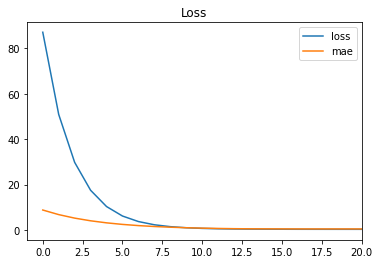

In [19]:
import matplotlib.pyplot as plt

# 20 epoch까지 Loss 수렴에 대한 시각화
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['mae'], label='mae')
plt.xlim(-1, 20)
plt.title('Loss')
plt.legend()
plt.show()

> 첫 10 epoch까지 손실이 급격히 감소 -> 이후에는 감소 폭이 둔화되면서 조금씩 감소
> 
> 모델 훈련 초기 단계에는 학습이 매우 빠른 속도로 진행되다가 일정 epoch 이후에는 학습 속도가 느려지는 패턴이 관찰됨

#### 2-9 검증
* 모델 인스턴스의 `evaluate()` 메소드 사용
* 모델이 훈련을 마친 상태의 가중치를 그대로 적용하여 손실과 평가지표 계산
* 사전에 별도의 검증 데이터셋을 준비하여 모델의 성능을 평가하는 것이 일반적 -> 교차 검증

In [20]:
# 검증
model.evaluate(x, y) # 별도의 검증 셋을 만들어 두지 않았으므로 훈련 데이터셋의 x, y 대입

1/1 [==============================] - 0s 472ms/step - loss: 8.7565e-05 - mae: 0.0080


[8.756529132369906e-05, 0.008031750097870827]

> 모델 훈련 단계에서 1200번 epoch를 종료한 상태에서 출력된 값과 동일

#### 2-10 예측
* 훈련 완료된 모델 인스턴스의 `predict()` 메소드에 새로운 입력 데이터를 리스트 형태로 넣어 모델의 예측 값 도출


In [21]:
# 예측
model.predict([10])

array([[32.03882]], dtype=float32)

> 예측 값 : 32.03882 -> 정답에 근사

### 03 심층 신경망으로 이미지 분류

#### 3-1 케라스 내장 데이터셋 로드
* `tensorflow.keras.datasets` 서브패키지에 샘플 데이터셋 위치
  
  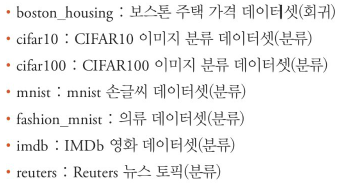

* 데이터 불러오기 : `load_data()`
  - 훈련/검증 데이터셋 구분하여 제공


In [22]:
import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

In [23]:
# load_data()로 데이터셋 로드
# 훈련 셋과 검증 셋을 튜플 형태로 정의
(x_train, y_train), (x_test, y_test) = mnist.load_data() # google의 storage로부터 넘파이 배열로 구성된 데이터셋 다운로드

11501568/11490434 [==============================] - 0s 0us/step


In [24]:
# 로드된 데이터셋 확인
print('train set: ', x_train.shape, y_train.shape)
print('test  set: ', x_test.shape, y_test.shape)

train set:  (60000, 28, 28) (60000,)
test  set:  (10000, 28, 28) (10000,)


> 훈련 셋 : 60000개의 데이터
>
> 검증 셋 : 10000개의 데이터

> 입력 데이터 : x_train, x_test
  - mnist 손글씨 데이터 저장
  - shape : (데이터셋 크기, 28, 28) -> 이미지의 세로, 가로의 픽셀 크기가 28 x 28
>
> 출력 데이터(정답) : y_train, y_test
  - 1차원 벡터 형태

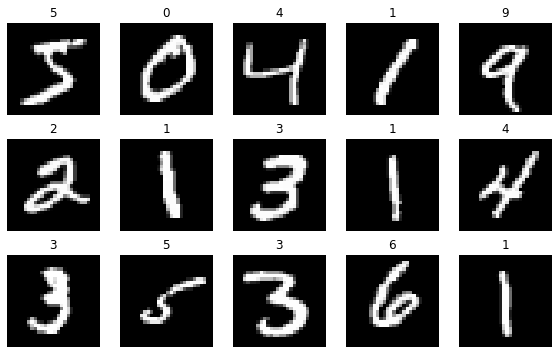

In [25]:
# 데이터 시각화
import matplotlib.pyplot as plt

# canvas 생성
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(8, 5)

# 훈련 셋에서 처음 15장에 대한 이미지 시각화
for i in range(15):
    ax = axes[i//5, i%5]
    # imshow로 이미지 시각화
    ax.imshow(x_train[i], cmap='gray')
    ax.axis('off')
    ax.set_title(str(y_train[i])) # 손글씨 이미지 상단에 정답을 함께 표시

plt.tight_layout()
plt.show()

* mnist 데이터셋 : 사람의 필기체로 쓰인 0~9까지의 숫자들로 이루어진 데이터셋
  - 0~9까지 총 10개의 정답 레이블로 구성

#### 3-2 데이터 전처리
* 이미지 데이터에 대하여 정규화를 통해 데이터의 범위 0~1 사이로 조절
  - 모델 학습 시 경사하강법 알고리즘에 의한 수렴 속도 향상
  -국소 최적에 빠지는 현상 방지

In [26]:
# x_train 배열의 데이터 확인
x_train[0, 10:15, 10:15]

array([[  1, 154, 253,  90,   0],
       [  0, 139, 253, 190,   2],
       [  0,  11, 190, 253,  70],
       [  0,   0,  35, 241, 225],
       [  0,   0,   0,  81, 240]], dtype=uint8)

> x_train 넘파이 배열의 각 원소는 이미지를 구성하는 하나의 픽셀 값과 일대일 매칭
>
> 0~255 범위의 값으로 구성

In [27]:
# 픽셀 값의 최소/최대 값 확인
print(f'정규화 전] 최소값: {x_train.min()}, 최대값: {x_train.max()}')

# 데이터 정규화
# 데이터가 0~1 사이의 값을 가지도록 데이터의 최대값인 255로 나눔
x_train = x_train / x_train.max()

# 정규화 후 최소/최대 값 확인
print(f'정규화 후] 최소값: {x_train.min()}, 최대값: {x_train.max()}')

정규화 전] 최소값: 0, 최대값: 255
정규화 후] 최소값: 0.0, 최대값: 1.0


In [28]:
# test 셋에도 정규화 동일 적용
x_test = x_test / x_test.max()

In [29]:
# 변환 후 x_train 배열의 데이터 확인
x_train[0, 10:15, 10:15]

array([[0.00392157, 0.60392157, 0.99215686, 0.35294118, 0.        ],
       [0.        , 0.54509804, 0.99215686, 0.74509804, 0.00784314],
       [0.        , 0.04313725, 0.74509804, 0.99215686, 0.2745098 ],
       [0.        , 0.        , 0.1372549 , 0.94509804, 0.88235294],
       [0.        , 0.        , 0.        , 0.31764706, 0.94117647]])

> 0~1 사이의 값이 출력

#### 3-3 Flatten 레이어

* 정규화를 하더라도 원본 배열의 형태는 그대로 유지
* 샘플 이미지의 형태는 (28, 28)의 2차원 입력
* Dense 레이어에는 입력값으로 반드시 1차원 배열이 들어가야 함
  1. 이미지 데이터를 1차원으로 전처리하여 주입
  2. Flatten 레이어를 사용하여 다차원 데이터를 1차원으로 펼치기

In [30]:
print(f'변경전 shape: {x_train.shape}') # 정규화가 끝난 x_train의 shape
print(f'1D으로 shape 변경 후: {x_train.reshape(60000, -1).shape}')

변경전 shape: (60000, 28, 28)
1D으로 shape 변경 후: (60000, 784)


In [31]:
print(f'변경전 shape: {x_train.shape}')

# Flatten 레이어 적용 후 shape 확인
print(f'Flatten 적용 후: {tf.keras.layers.Flatten()(x_train).shape}')

변경전 shape: (60000, 28, 28)
Flatten 적용 후: (60000, 784)


> 784는 가로 세로 픽셀 수를 곱한 값 (28 * 28 = 784)

#### 3-4 활성화 함수
* 입력을 비선형 출력으로 변환해주는 함수
  - 일반적으로 선형관계를 나타내는 함수에 비선형성을 추가하는 방법으로 표현
  - 비선형성을 추가하지 않고 선형 함수로만 층을 구성 -> 모델을 깊게 구성하더라도 선형함수로 표현
* 자주 사용되는 활성화 함수 : 시그모이드(Sigmoid), 하이퍼볼릭 탄젠트(tanh), ReLU(Rectified Unit), Leaky ReLU 등
* 텐서플로는 주요 활성화 함수를 클래스형과 함수형으로 제공
* 텐서플로 케라스 레이어에 활성화 함수 적용하는 방법
 1. Dense 레이어의 `activation` 매개 변수에 문자열 대입
 2. 별도의 층처럼 적용 : 레이어 구성을 좀 더 커스터마이징하고 싶을 때 구분하여 처리
  
    - Dense 레이어 다음에 배치 정규화를 적용한 후 활성화 함수를 적용하고자 할 때 많이 사용

In [32]:
# Dense 레이어에 relu 활성화 함수를 적용한 경우
tf.keras.layers.Dense(128, activation='relu')

In [33]:
# Dense 레이어와 relu 활성화 함수 레이어를 별도 적용한 경우
model = tf.keras.Sequential([
        tf.keras.layers.Dense(128), 
        tf.keras.layers.Activation('relu')
])

#### 3-5 입력과 출력
* 첫 번째 레이어 : 입력 데이터의 형태를 나타내는 `input_shape` 매개변수 지정
  - 데이터셋 크기를 제외하고 이미지의 세로, 가로 형태를 input_shape으로 지정
* 마지막 레이어(출력층) : 분류 모델 출력층의 노드 개수는 반드시 분류해야 될 클래스의 개수와 동일

In [34]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)), # x_train shape : (60000, 28, 28)
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(32, activation='relu'), 
        # 노드=10개(클래스 개수와 동일) # mnist는 0~9까지 총 10개의 클래스로 구성
        tf.keras.layers.Dense(10, activation='softmax'), 
])

> Dense 레이어를 구성하는 노드의 개수가 줄어드는 형태
>  
>  -> 784개의 변수(Flatten 층으로 이미지를 펼쳐 얻은 784개의 픽셀 값)에 대한 입력값을 노드 개수를 줄여가면서 최종 출력 클래스 개수 10개까지 정보를 축약하기 위한 설계

* 다중 분류 : 출력층의 노드 개수가 2개 이상인 경우 -> softmax 활성화 함수
* 이진 분류
  - 출력층 노드 개수를 1개로 설정한 경우 -> sigmoid 활성화 함수
  - 출력 레이어 클래스가 원핫 인코딩으로 변환되어 노드 개수가 2개인 경우 -> softmax 활성화 함수


In [35]:
# 출력층 노드 = 1인 경우, sigmoid
tf.keras.layers.Dense(1, activation='sigmoid')

# 출력층 노드 = 2개 이상인 경우, softmax
tf.keras.layers.Dense(10, activation='softmax')

#### 3-6 손실함수

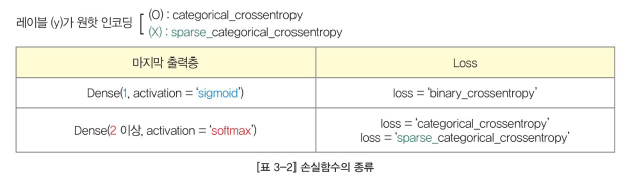

출력 노드가 1개, sigmoid 활성화 함수를 적용한 경우

In [36]:
# 이진 분류(출력 노드 개수 = 1, sigmoid 인 경우)
model.compile(loss='binary_crossentropy')

출력 노드가 2개 이상, softmax 활성화 함수를 적용한 경우

In [37]:
# y가 원핫 벡터인 경우
# [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
model.compile(loss='categorical_crossentropy')
# y가 원핫 벡터가 아닌경우
# [5]
model.compile(loss='sparse_categorical_crossentropy')

* mnist 손글씨 데이터셋 : 출력 데이터가 원핫 벡터가 아니고, 0~9까지의 레이블 값

  -> 손실함수로 `sparse_categorical_crossentropy` 지정

#### 3-7 옵티마이저
* 손실을 낮추기 위해서, 신경망의 가중치와 학습률과 같은 신경망의 속성을 변경하는 데 사용되는 최적화 방법
* 케라스에서 지원하는 옵티마이저 목록
  
  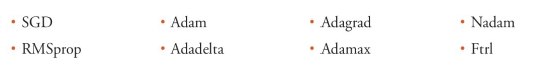

  - 대체적으로 좋은 성능을 발휘하는 Adam 알고리즘을 많이 사용

* 옵티마이저 지정하는 방법
  1. 클래스 인스턴스로 지정 : 학습률과 같은 하이퍼파라미터 직접 설정 가능
  2. 문자열로 지정 : 클래스 이름을 소문자로 표기

In [38]:
# 클래스 인스턴스로 지정
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam)

# 문자열로 지정
model.compile(optimizer='adam') 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### 3-8 평가지표
* 분류 모델에 대한 평가지표
  - 정확도 'accuracy'('acc')가 가장 많이 사용
  - 그 외 'auc', 'precision', 'recall'
* 모델 컴파일 단계에서 `compile()` 메소드의  `metrics` 매개변수에 파이썬 리스트 형태로 하나 이상의 평가지표 지정하여 동시에 참고 가능

In [39]:
# 클래스 인스턴스로 지정
acc = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=[acc])

In [40]:
# 문자열로 지정
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#### 3-9 훈련
* 모델 훈련 시 검증 셋을 추가 지정하면, 매 epoch마다 훈련 손실과 검증 손실, 각 셋에 대한 평가지표를 나란히 출력
  - `validation_data` 매개변수에 튜플 형식의 검증 셋을 지정

In [41]:
# 훈련
model.fit(x_train, y_train, 
          # 검증 셋 지정
          validation_data=(x_test, y_test), 
          epochs=10, 
          )

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2326 - accuracy: 0.9312 - val_loss: 0.1180 - val_accuracy: 0.9615
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0937 - accuracy: 0.9713 - val_loss: 0.1152 - val_accuracy: 0.9639
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0653 - accuracy: 0.9796 - val_loss: 0.0871 - val_accuracy: 0.9741
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0510 - accuracy: 0.9842 - val_loss: 0.0833 - val_accuracy: 0.9746
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0383 - accuracy: 0.9876 - val_loss: 0.0747 - val_accuracy: 0.9791
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0335 - accuracy: 0.9888 - val_loss: 0.0995 - val_accuracy: 0.9731
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0277 - accuracy: 0.9908 - val_loss: 0.0837 - val_accuracy:

#### 3-10 평가
* 모델 성능 검증 및 평가 결과 확인 : `evaluate(x_test, y_test)`

In [42]:
# 검증
test_loss, test_acc = model.evaluate(x_test, y_test)

print('검증 셋 정확도:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1054 - accuracy: 0.9744
검증 셋 정확도: 0.974399983882904


>  컴파일 단계에서 지정한 손실과 정확도 순서대로 반환
>
> 모델의 검증 성능(정확도) : 약 97.4%

#### 3-11 예측
* `predict()` 메소드에 이미지 데이터를 넣어주며 모델의 예측 결과 반환

In [43]:
# 예측
# 예측에 필요한 새로운 데이터셋이 준비되어 있지 않기 때문에 검증 데이터셋의 입력 데이터 x_test 사용
predictions = model.predict(x_test) 

> predictions : 모델이 분류한 예측 결과를 담은  넘파이 배열

In [44]:
# 예측 결과 출력
predictions[0]

array([7.4542091e-12, 2.1463367e-09, 7.0806649e-09, 8.1895468e-09,
       3.4112390e-11, 3.1800472e-12, 2.5296036e-14, 9.9999976e-01,
       1.0992805e-11, 1.9741438e-07], dtype=float32)

> 출력층의 노드 개수 10개 -> softmax 활성화 함수를 거친 10개의 확률값들이 출력
>
> => 0~9까지의 10개의 개별 클래스에 대한 분류 확률값

* 최종 예측된 클래스 = 가장 높은 확률값을 가진 클래스
  - 넘파이 배열의 `argmax`로 확인

In [45]:
import numpy as np

# 0번 index에 대한 예측 클래스 출력
print(np.argmax(predictions[0]))

# 첫 10개 index에 대한 예측 클래스 출력
print(np.argmax(predictions[:10], axis=1))

7
[7 2 1 0 4 1 4 9 5 9]


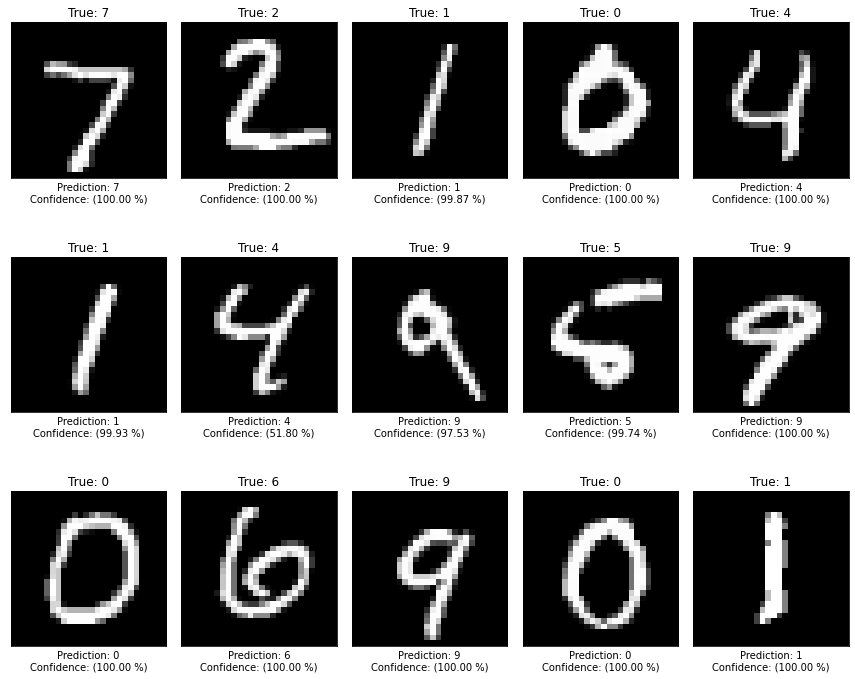

In [46]:
# 데이터 시각화
import matplotlib.pyplot as plt

def get_one_result(idx):
    img, y_true, y_pred, confidence = x_test[idx], y_test[idx], np.argmax(predictions[idx]), 100*np.max(predictions[idx])
    return img, y_true, y_pred, confidence
    
# canvas 생성
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 10)
for i in range(15):
    ax = axes[i//5, i%5]
    img, y_true, y_pred, confidence = get_one_result(i)
    # imshow로 이미지 시각화
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'True: {y_true}')
    ax.set_xlabel(f'Prediction: {y_pred}\nConfidence: ({confidence:.2f} %)')
plt.tight_layout()
plt.show()

### 04 모델 세부 설정

입력 데이터 준비

In [47]:
import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋을 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터셋 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 로드된 데이터셋 확인
print('train set: ', x_train.shape, y_train.shape)
print('test  set: ', x_test.shape, y_test.shape)

# 데이터 정규화
x_train = x_train / x_train.max() # max: 255
x_test = x_test / x_test.max() # max: 255

train set:  (60000, 28, 28) (60000,)
test  set:  (10000, 28, 28) (10000,)


#### 4-1 초기값 설정
* Dense 레이어의 기본 초기화 방법 : Glorot Uniform
* `kernel_initializer` 매개변수로 초기화 방법 변경
* 자주 사용되는 초기화 목록

  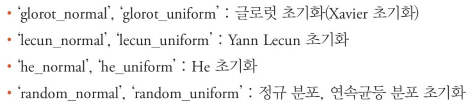


In [48]:
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()['kernel_initializer']

{'class_name': 'GlorotUniform', 'config': {'seed': None}}

In [50]:
# 문자열 초기화
dense = tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')
print(dense.get_config()['kernel_initializer'])

# 클래스 인스턴스 초기화
he_normal = tf.keras.initializers.HeNormal()
dense = tf.keras.layers.Dense(256, kernel_initializer=he_normal, activation='relu')
print(dense.get_config()['kernel_initializer'])

{'class_name': 'HeNormal', 'config': {'seed': None}}
{'class_name': 'HeNormal', 'config': {'seed': None}}


#### 4-2 규제(Regularization)
* 모델의 과대적합을 해소하기 위해 레이어마다 L1, L2 규제 적용 가능
* 기본값 : 규제 적용 하지 않음
* `kernel_regularizer`에 규제 지정

In [51]:
# 기본값
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense_26',
 'trainable': True,
 'units': 256,
 'use_bias': True}

> kernel_regularizer 설정이 None

In [52]:
# l1 규제 적용
dense = tf.keras.layers.Dense(256, kernel_regularizer='l1', activation='relu')
print(dense.get_config()['kernel_regularizer'])

# 클래스 인스턴스 적용, alpha=0.1 변경
regularizer = tf.keras.regularizers.l1(l1=0.1)
dense = tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu')
print(dense.get_config()['kernel_regularizer'])

{'class_name': 'L1', 'config': {'l1': 0.009999999776482582}}
{'class_name': 'L1', 'config': {'l1': 0.10000000149011612}}


#### 4-3 드롭아웃(Dropout)
* 딥러닝 모델의 층이 넓고 깊어질 때 모델은 과대적합 -> 훈련 데이터셋에 너무 적응하여 검증 데이터셋이나 테스트 데이터셋에 대해 일반화된 성능을 갖지 못하는 문제가 자주 발생
* 드롭아웃 : 노드의 일부 신호를 임의로 삭제해 모델이 학습하는 가중치 파라미터의 개수를 감소시켜 과대적합을 방지하는 방법

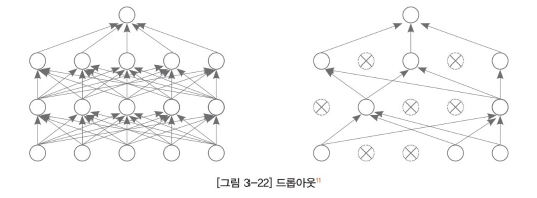

* 모델이 훈련할 때는 드롭아웃이 적용되어 노드 중 일부만 훈련하지만, 예측 시점에는 모든 노드들이 활용

In [53]:
# Dropout 25% 비율 적용(25%의 노드가 삭제)
tf.keras.layers.Dropout(0.25)

#### 4-4 배치 정규화(Batch Normalization)
* 각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일을 정규화  
* 다음 층으로 데이터가 전달되기 전에 스케일을 조정 -> 보다 안정적인 훈련 가능, 성능 크게 향상
* 클래스 인스턴스를 생성하여 추가
* 크고 복잡한 데이터셋에서 배치 정규화 유무가 모델 성능에 크게 영향을 미치는 경우 有

In [54]:
# Model A: Dense + ReLU
model_a = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(28, 28)),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(10, activation='softmax'),
])
model_a.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_29 (Dense)            (None, 64)                50240     
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Model B: Dense + BatchNorm + ReLU
model_b = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(28, 28)),
          tf.keras.layers.Dense(64),
          # 배치 정규화 적용
          tf.keras.layers.BatchNormalization(),
          # 배치 정규화 후 활성화 함수 적용
          tf.keras.layers.Activation('relu'),

          tf.keras.layers.Dense(32),
          # 배치 정규화 적용
          tf.keras.layers.BatchNormalization(),
          # 배치 정규화 후 활성화 함수 적용
          tf.keras.layers.Activation('relu'),

          tf.keras.layers.Dense(10, activation='softmax'),
])
model_b.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                      

* 동일한 조건에서 10번의 epoche동안 model_a, model_b를 훈련한 결과

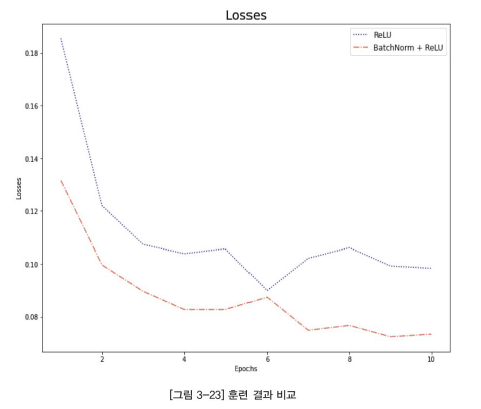

> 배치 정규화 추가 -> 손실은 이전 대비 더 안정적이고 빠르게 수렴

#### 4-5 활성화(activation) 함수


In [56]:
# LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

# LeakyReLU, alpha=0.2로 변경
tf.keras.layers.LeakyReLU(alpha=0.2) # 클래스 인스턴스로 선언해 하이퍼파라미터 값 변경하여 적용

In [57]:
# Model C: Dense + BatchNorm + LeakyReLU(0.2)
model_c = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(28, 28)),
          tf.keras.layers.Dense(64),
          # 배치 정규화 적용
          tf.keras.layers.BatchNormalization(),
          # LeakyReLU, alpha=0.2 적용
          tf.keras.layers.LeakyReLU(alpha=0.2),

          tf.keras.layers.Dense(32),
          # 배치 정규화 적용
          tf.keras.layers.BatchNormalization(),
          # LeakyReLU, alpha=0.2 적용
          tf.keras.layers.LeakyReLU(alpha=0.2),

          tf.keras.layers.Dense(10, activation='softmax'),
])

# 모델 요약
model_c.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_35 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                      

3개의 모델을 동일한 조건으로 10번의 epoch 동안 훈련한 후 수렴 속도 확인

In [58]:
model_a.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model A: Dense + ReLU
history_a = model_a.fit(x_train, y_train, 
                        validation_data=(x_test, y_test), 
                        epochs=10)

# Model B: Dense + BatchNorm + ReLU
history_b = model_b.fit(x_train, y_train, 
                        validation_data=(x_test, y_test), 
                        epochs=10)

# Model C: Dense + BatchNorm + LeakyReLU(0.2)
history_c = model_c.fit(x_train, y_train, 
                        validation_data=(x_test, y_test), 
                        epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2913 - accuracy: 0.9168 - val_loss: 0.1506 - val_accuracy: 0.9541
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1321 - accuracy: 0.9609 - val_loss: 0.1221 - val_accuracy: 0.9637
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0991 - accuracy: 0.9700 - val_loss: 0.1052 - val_accuracy: 0.9667
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0783 - accuracy: 0.9764 - val_loss: 0.1060 - val_accuracy: 0.9694
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0648 - accuracy: 0.9798 - val_loss: 0.0937 - val_accuracy: 0.9718
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0552 - accuracy: 0.9825 - val_loss: 0.0888 - val_accuracy: 0.9730
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0478 - accuracy: 0.9848 - val_loss: 0.0919 - val_accuracy:

결과를 시각화하여 epoch별 검증 손실의 감소 추이 확인

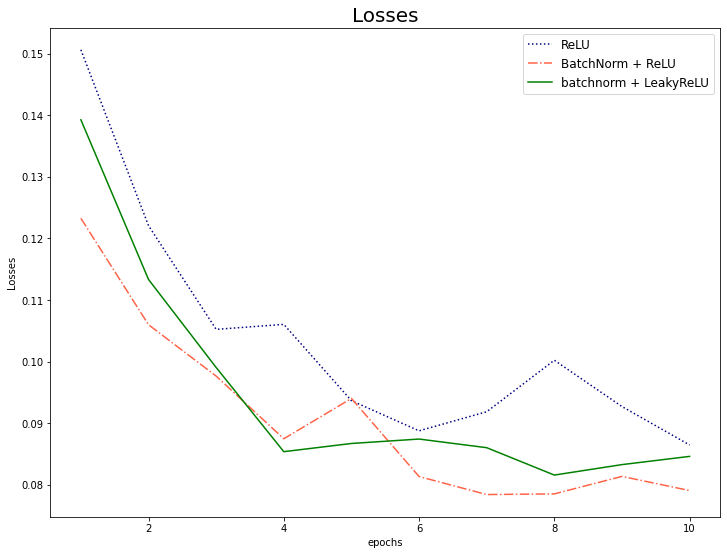

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, 11), history_a.history['val_loss'], color='navy', linestyle=':')
plt.plot(np.arange(1, 11), history_b.history['val_loss'], color='tomato', linestyle='-.')
plt.plot(np.arange(1, 11), history_c.history['val_loss'], color='green', linestyle='-')

plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.legend(['ReLU', 'BatchNorm + ReLU','batchnorm + LeakyReLU'], fontsize=12)
plt.show()

> mnist 데이터셋은 모델별 차이가 크지는 않음